# パラメータチューニングの実践

**07-決定木モデルの作成** で作成した決定木モデルのパラメータをチューニングする

## 対象データ

ここではSIGNATEの[【練習問題】銀行の顧客ターゲティングデータ](https://signate.jp/competitions/1/data)を使用している

### train.csv（学習データ）

* 説明変数：目的変数以外の全て
* 目的変数：y（定額預金申し込み有無）

### test.csv（評価データ）

* 説明変数：全て



## データの準備

ライブラリのインポート

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

CSVデータの読み込み

In [2]:
train = pd.read_csv('data/customer_targeting/train.csv')
test = pd.read_csv('data/customer_targeting/test.csv')
sample = pd.read_csv('data/customer_targeting/submit_sample.csv', header=None)

## 説明変数と目的変数の設定

### 学習データの説明変数を抽出する

目的変数y以外のカラムを説明変数に設定する

In [3]:
trainX = train.iloc[:, 0:17]

学習データの目的変数を抽出する

In [4]:
y = train['y']

### 評価データの説明変数を抽出する

全カラムを説明変数に設定する

In [5]:
testX = test.copy()

質的データをダミー変数化する

In [6]:
trainX = pd.get_dummies(trainX)
testX = pd.get_dummies(testX)

train と test で one-hot 後の列を揃える（列ズレ防止）

In [7]:
testX = testX.reindex(columns=trainX.columns, fill_value=0)

## モデルの準備

### モデルを表す変数を用意する

* 何個も作る可能性があるため項番を付与した変数にする
* パラメータは一旦、前回と同じにする

In [8]:
clf1 = DT(max_depth=2, min_samples_leaf=500)

## クロスバリデーションでモデルの精度を確認する

### fit関数（説明変数、目的変数の順に指定）でモデルを作成する

オプションの説明
* cv：データ分割数（Kに相当）
* scoring：評価尺度
* n_jobs：並列処理をするかどうか（-1で全てのCPUコア数を使用）

In [9]:
cross_validate(clf1, trainX, y, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)

{'fit_time': array([0.06077909, 0.0762639 , 0.06414247, 0.06587815, 0.06274581]),
 'score_time': array([0.00557971, 0.00614023, 0.01625299, 0.01440048, 0.00988913]),
 'test_score': array([0.74657601, 0.76182968, 0.73117591, 0.73707281, 0.75910043]),
 'train_score': array([0.74534692, 0.74543889, 0.75305367, 0.75162494, 0.746135  ])}

以下の精度に大差がないことが確認できる
* test_scoreで分割されたそれぞれの精度
* train_scoreで分割されたそれぞれの精度
* test_scoreとtrain_scoreの精度

## パラメータを変えて再度実行する

In [10]:
clf2 = DT(max_depth=10, min_samples_leaf=500)
cross_validate(clf2, trainX, y, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)

{'fit_time': array([0.10990834, 0.11330223, 0.11458135, 0.138556  , 0.13340163]),
 'score_time': array([0.00601268, 0.        , 0.        , 0.00699782, 0.01008534]),
 'test_score': array([0.88264002, 0.88482571, 0.86778474, 0.89239853, 0.88343681]),
 'train_score': array([0.88842017, 0.89038512, 0.89288003, 0.8876343 , 0.885615  ])}

## グリッドサーチによるパラメータ探索

* 指定したパラメータ範囲の中で最適な精度を確認する方法
* 1つ1つパラメータを設定して精度を確かめる手間がない

## モデルの準備

新しく決定木モデルを表す変数を用意する

In [11]:
clf3 = DT()

探索するパラメータ範囲を表す変数を用意する

ここではmax_pedpthを2から10まで探索する

In [12]:
parameters = {'max_depth':[2, 3, 4, 5, 6, 7, 8, 9, 10]}

rangeを使った書き方

In [13]:
parameters = {'max_depth':list(range(2, 11))}

変数の内容を確認する

In [14]:
parameters

{'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]}

## グリッドサーチとクロスバリデーションを組み合わせて最適なパラメータを探す

グリッドサーチの結果を変数gcvに代入し、fit関数を使って探索を実行する

In [15]:
gcv = GridSearchCV(clf3, parameters, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
gcv.fit(trainX, y)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",DecisionTreeClassifier()
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'max_depth': [2, 3, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed;- >3 : the fold and candidate parameter

結果を表示する

In [16]:
gcv.cv_results_

{'mean_fit_time': array([0.06616287, 0.09241853, 0.12053018, 0.13347921, 0.18016419,
        0.19759722, 0.24362535, 0.29255514, 0.26086998]),
 'std_fit_time': array([0.00750031, 0.02001924, 0.01160323, 0.00686234, 0.01013228,
        0.02328425, 0.05545579, 0.04577975, 0.03588397]),
 'mean_score_time': array([0.00784593, 0.00717335, 0.0084424 , 0.00700784, 0.00667582,
        0.00869279, 0.01397295, 0.0107192 , 0.00783739]),
 'std_score_time': array([0.00153658, 0.00109509, 0.0008116 , 0.0004153 , 0.00050455,
        0.00294328, 0.00707436, 0.00198462, 0.000764  ]),
 'param_max_depth': masked_array(data=[2, 3, 4, 5, 6, 7, 8, 9, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value=999999),
 'params': [{'max_depth': 2},
  {'max_depth': 3},
  {'max_depth': 4},
  {'max_depth': 5},
  {'max_depth': 6},
  {'max_depth': 7},
  {'max_depth': 8},
  {'max_depth': 9},
  {'max_depth': 10}],
 'split0_test_score': array([0.746

結果から重要な項目だけ取り出す

In [17]:
train_score = gcv.cv_results_['mean_train_score']
test_score = gcv.cv_results_['mean_test_score']

## 取り出した項目を可視化する

### x軸をmax_depth、y軸をaucとしてグラフを描く

このモデルではmax_depthの最小値を2に設定しているのでx軸を0～9から2～10に調整する

* 青：モデル構築用データ
* 橙：モデル検証用データ

([<matplotlib.axis.XTick at 0x20583b50ed0>,
 [Text(0, 0, '2'),
  Text(1, 0, '3'),
  Text(2, 0, '4'),
  Text(3, 0, '5'),
  Text(4, 0, '6'),
  Text(5, 0, '7'),
  Text(6, 0, '8'),
  Text(7, 0, '9'),
  Text(8, 0, '10')])

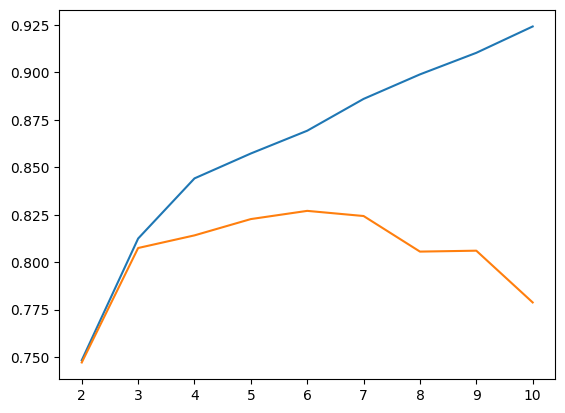

In [18]:
plt.plot(train_score)
plt.plot(test_score)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['2', '3', '4', '5', '6', '7', '8', '9', '10'])

### パラメータの最適値を表示する

検証用データの精度が高く、構築用データとの乖離が少ない箇所を確認する

In [19]:
gcv.best_params_

{'max_depth': 6}

## 評価データの予測

### 予測結果を変数に代入する

gcvもpredict_proba関数を持っており、自動的に最適なパラメータを使ったモデルで予測される

'max_depth': 6 を使った予測結果が代入される

In [21]:
# predict_proba の戻りを ndarray として扱い、クラス1の確率だけを取り出す
pred = np.asarray(gcv.predict_proba(testX))[:, 1]

## モデルの評価

### SIGNATEで評価する形式にデータを加工する

sampleファイルのカラム[1]に、予測結果を代入する

In [22]:
sample[1] = pred

sampleをCSVファイルに書き出す

In [23]:
sample.to_csv('data/customer_targeting/output_submit2_bank.csv', index=False, header=False)


書き出したファイルを[SIGNATE](https://signate.jp/competitions/1/data)に投稿して評価を確認する